# Expedia Hotel Recommendations

## 1. Framing the Business Problem

**This is Kaggle competition that took place 5yrs ago. The following has been extracted from Kaggle.com.**


Planning your dream vacation, or even a weekend escape, can be an overwhelming affair. With hundreds, even thousands, of hotels to choose from at every destination, it's difficult to know which will suit your personal preferences. Should you go with an old standby with those pillow mints you like, or risk a new hotel with a trendy pool bar?

Expedia wants to take the proverbial rabbit hole out of hotel search by providing personalized hotel recommendations to their users. This is no small task for a site with hundreds of millions of visitors every month!

Currently, Expedia uses search parameters to adjust their hotel recommendations, but there aren't enough customer specific data to personalize them for each user. In this competition, Expedia is challenging Kagglers to contextualize customer data and predict the likelihood a user will stay at 100 different hotel groups.

The data in this competition is a random selection from Expedia and is not representative of the overall statistics.

Expedia has provided us logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

Our goal is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.

Submissions are evaluated according to the Mean Average Precision @ 5.

For every user event, you must predict a space-delimited list of the hotel clusters they booked. You may submit up to 5 predictions for each user event. The file should contain a header and have the following format:

## 2. Loading libraries and dataset

In [101]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [102]:
## Given the length of the train dataset, I've decided to shorten it.
train=pd.read_csv('train.csv.zip', nrows=10000)
test=pd.read_csv('test.csv', nrows=10000)

**Comments**

Creating a subset of a Dataset means removing variables or observations. Doing it in this way without further analysis, could eventually bring bias. We are not 100% sure of how the dataset has been retrieved, if we only work with a piece of information but not taking that piece through sampling in the proper way, 

This particular Dataset contains 37 million logs of customer behaviour, to avoid the need of a high computational power (or time), I will only work using a subset that has been taken without considering all the sampling principles and best practices.

## 3. Exploratory Data Analysis (EDA)

In [103]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [104]:
train.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

In [105]:
test.head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


**Comments**

All the dates in test dataset are 1 year later than the dates in train. The testing set contains dates from 2015, and the training set contains dates from 2013 and 2014. This could eventually bring issues if the two datasets are not similar from a sampling/population standpoint, hence it may have some bias. 

In [106]:
#checking the information of the dataset and columns types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  10000 non-null  object 
 1   site_name                  10000 non-null  int64  
 2   posa_continent             10000 non-null  int64  
 3   user_location_country      10000 non-null  int64  
 4   user_location_region       10000 non-null  int64  
 5   user_location_city         10000 non-null  int64  
 6   orig_destination_distance  6271 non-null   float64
 7   user_id                    10000 non-null  int64  
 8   is_mobile                  10000 non-null  int64  
 9   is_package                 10000 non-null  int64  
 10  channel                    10000 non-null  int64  
 11  srch_ci                    9993 non-null   object 
 12  srch_co                    9993 non-null   object 
 13  srch_adults_cnt            10000 non-null  int6

In [107]:
test.head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


**Comments**

- Descriptions of each columns has been provided by Expedia in Kaggle. Hence, no need to explain them again.
- We need to parse date time format to the columns that contains dates.

In [108]:
#reloading the dataset with date_time formats
train = pd.read_csv('train.csv.zip', parse_dates=['date_time'] ,sep=',',nrows=10000)

In [109]:
train.shape

(10000, 24)

In [110]:
#rechecking the date_time formats
train.dtypes

date_time                    datetime64[ns]
site_name                             int64
posa_continent                        int64
user_location_country                 int64
user_location_region                  int64
user_location_city                    int64
orig_destination_distance           float64
user_id                               int64
is_mobile                             int64
is_package                            int64
channel                               int64
srch_ci                              object
srch_co                              object
srch_adults_cnt                       int64
srch_children_cnt                     int64
srch_rm_cnt                           int64
srch_destination_id                   int64
srch_destination_type_id              int64
is_booking                            int64
cnt                                   int64
hotel_continent                       int64
hotel_country                         int64
hotel_market                    

In [111]:
train.describe()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,6271.000000,10000.000000,10000.000000,10000.000000,10000.00000,...,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8.261400,2.744400,85.711700,272.578700,26941.592000,1833.809641,29121.770900,0.206600,0.220100,5.70210,...,0.349100,1.12780,14807.539200,2.641100,0.077700,1.456100,3.149200,80.198000,575.825700,49.120100
std,10.352004,0.590511,61.545901,178.451546,17472.051101,2028.265606,17115.773996,0.404886,0.414335,3.59959,...,0.761241,0.55308,11454.009352,2.203446,0.267712,1.167565,1.539213,55.267289,494.452768,28.705492
min,2.000000,0.000000,0.000000,0.000000,3.000000,0.065100,12.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,11.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,66.000000,172.000000,9876.000000,261.557950,12950.000000,0.000000,0.000000,2.00000,...,0.000000,1.00000,8268.000000,1.000000,0.000000,1.000000,2.000000,50.000000,142.000000,25.000000
50%,2.000000,3.000000,66.000000,258.000000,25954.000000,1210.896700,30977.000000,0.000000,0.000000,9.00000,...,0.000000,1.00000,10970.500000,1.000000,0.000000,1.000000,2.000000,50.000000,544.000000,48.000000
75%,11.000000,3.000000,69.000000,354.000000,43175.000000,2397.099800,44663.000000,0.000000,0.000000,9.00000,...,0.000000,1.00000,18714.000000,5.000000,0.000000,1.000000,4.000000,105.000000,700.000000,73.000000
max,47.000000,4.000000,239.000000,1003.000000,56451.000000,11301.871400,54404.000000,1.000000,1.000000,9.00000,...,9.000000,8.00000,65035.000000,8.000000,1.000000,23.000000,6.000000,208.000000,2103.000000,99.000000


In [112]:
#checking for empty information
train.isnull().sum()

date_time                       0
site_name                       0
posa_continent                  0
user_location_country           0
user_location_region            0
user_location_city              0
orig_destination_distance    3729
user_id                         0
is_mobile                       0
is_package                      0
channel                         0
srch_ci                         7
srch_co                         7
srch_adults_cnt                 0
srch_children_cnt               0
srch_rm_cnt                     0
srch_destination_id             0
srch_destination_type_id        0
is_booking                      0
cnt                             0
hotel_continent                 0
hotel_country                   0
hotel_market                    0
hotel_cluster                   0
dtype: int64

<AxesSubplot:>

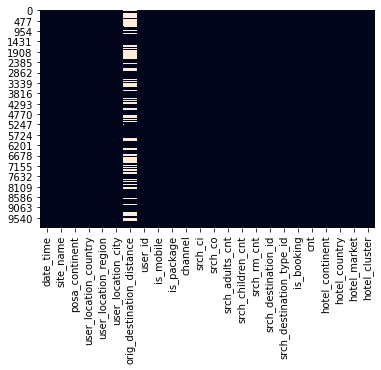

In [113]:
#visual heatmap of missing cells in train dataset
sns.heatmap(train.isnull(), cbar=False)

In [114]:
#constructing a table with % of missing cells to see how relevant they are.
total=train.isnull().sum().sort_values(ascending=False)
percent=(train.isnull().sum()/train['hotel_cluster'].count()).sort_values(ascending=False)
missing_data=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
orig_destination_distance,3729,0.3729
srch_ci,7,0.0007
srch_co,7,0.0007
channel,0,0.0000
site_name,0,0.0000
posa_continent,0,0.0000
user_location_country,0,0.0000
user_location_region,0,0.0000
user_location_city,0,0.0000
user_id,0,0.0000


In [115]:
total=test.isnull().sum().sort_values(ascending=False)
percent=(train.isnull().sum()/train['hotel_cluster'].count()).sort_values(ascending=False)
missing_data=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'], sort=False)
missing_data.head(20)

,Total,Percent
orig_destination_distance,4107.0,0.3729
hotel_market,0.0,0.0000
hotel_country,0.0,0.0000
date_time,0.0,0.0000
site_name,0.0,0.0000
posa_continent,0.0,0.0000
user_location_country,0.0,0.0000
user_location_region,0.0,0.0000
user_location_city,0.0,0.0000
user_id,0.0,0.0000


In [116]:
#remove the missing values & impute values for orig_destination_distance
train['orig_destination_distance'].fillna(train['orig_destination_distance'].mean(), inplace=True)
test['orig_destination_distance'].fillna(test['orig_destination_distance'].mean(), inplace=True)

**Comments**
- I used mean to preserve the original mean and to be and to avoid changing the distribution, as I lack necessary information to correctly input the value. In a business context this will imply getting back to the client to understand why there is so much missing values. Usually, analysts plug in missing values using mean or median as a quick solution, but this has consequences that we can't ignore. It's just an easily implemented approach. Model-based imputations are superior and less biased than this solution. Nevertheless, I'll leave it to a further analysis to improve my model. Again, I would get back to the Client to figure it out.

In [117]:
train.isnull().sum()

date_time                    0
site_name                    0
posa_continent               0
user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
user_id                      0
is_mobile                    0
is_package                   0
channel                      0
srch_ci                      7
srch_co                      7
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
is_booking                   0
cnt                          0
hotel_continent              0
hotel_country                0
hotel_market                 0
hotel_cluster                0
dtype: int64

In [118]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [119]:
train.shape

(9993, 24)

In [120]:
test.shape

(10000, 22)

### 3.1 Correlation

<AxesSubplot:>

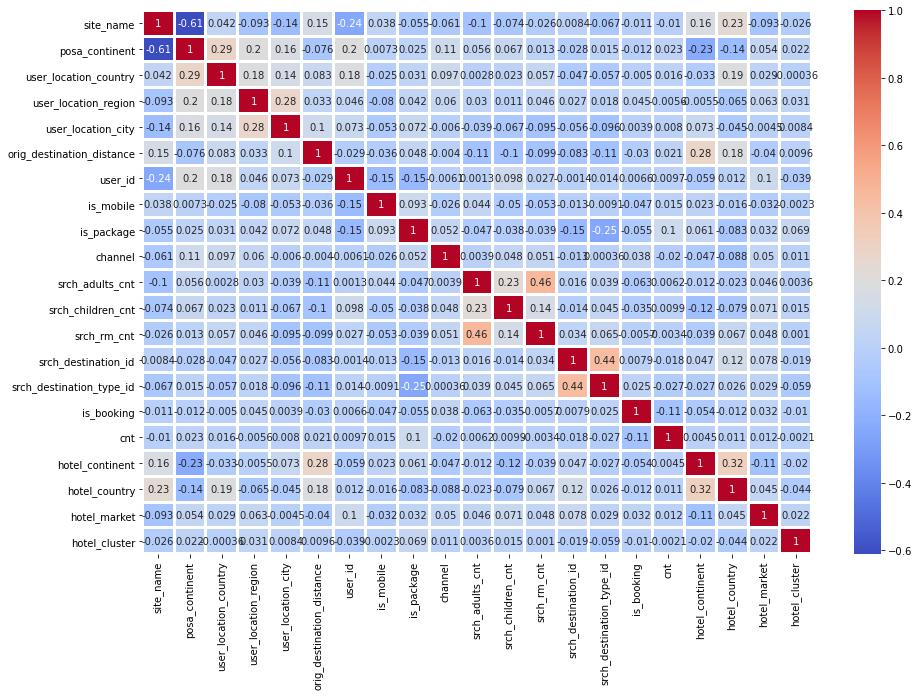

In [121]:
#visualizing through a heatmap to infer the correlation between different columns with each other and to check if there is any linear correlation between columns
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(train.corr(),cmap='coolwarm',ax=ax,annot=True,linewidths=2)

**Comments**
- There is no column linearly correlated with any other column in the dataset.
- The strongest correlation is given by search destination type and search destination id which is quite obvious.
- Hotel Country and Hotel Continent have the same correlation

### 3.2 Bivariate analysis

<AxesSubplot:xlabel='is_mobile', ylabel='count'>

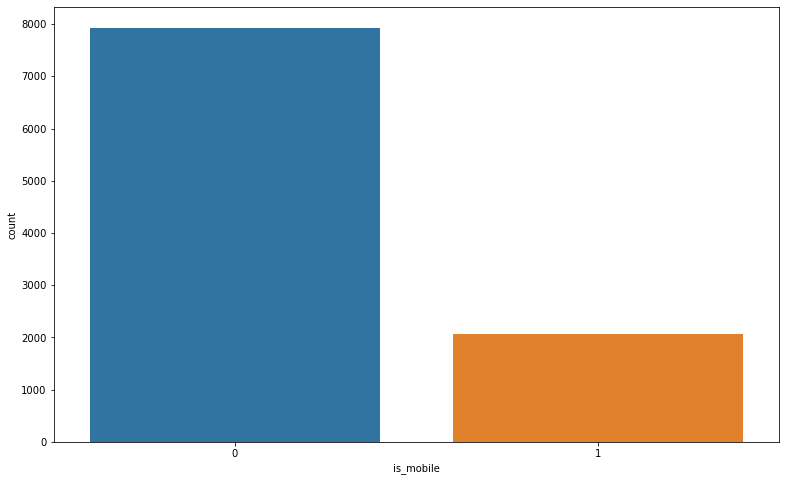

In [122]:
#understanding how are bookings places (i.e app or website)
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot(x='is_mobile',data=train, order=[0,1],ax=ax)

**Comments**
- It looks like Expedia app is not used as often as it's website. This could be related to cultural things (for example if adult people less related with technology is the typical customer), or maybe it could be related with the fact that when you plan a trip, you rather use a spreadsheet with multiple information and not only looking for a destination. In my personal case, when I plan a mid-long trip or vacations, I like to use my laptop, look in multiple websites at the same time, assemble a spreadsheet with a lot of information, etc.
- In either way, in a business consultancy situation we should get back to ou Client and gather more information or talk with the product manager to understand a little bit more about the customer journey.

<AxesSubplot:xlabel='is_package', ylabel='count'>

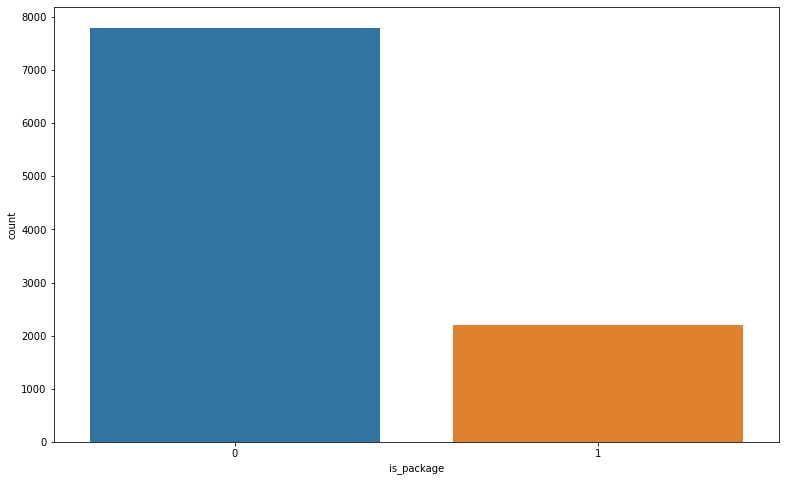

In [123]:
#frequency of bookings as a package (opposed to as a single travel)
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot(x='is_package',data=train, order=[0,1], ax=ax)

**Comments**
- The number of customers booking their hotels with total package is visible less. Again, not knowing things related to our clients (for example the customer journey) and not having the possibility to discuss further with them, one could interpret  it as a pricing problem (packages are too expensive maybe?), an availability problem (less range of hotels) maybe the packages are not flexible or appealing enough. Once again, this would require to get back to our Client.

C:\Users\sebastian.spena\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='posa_continent', ylabel='count'>

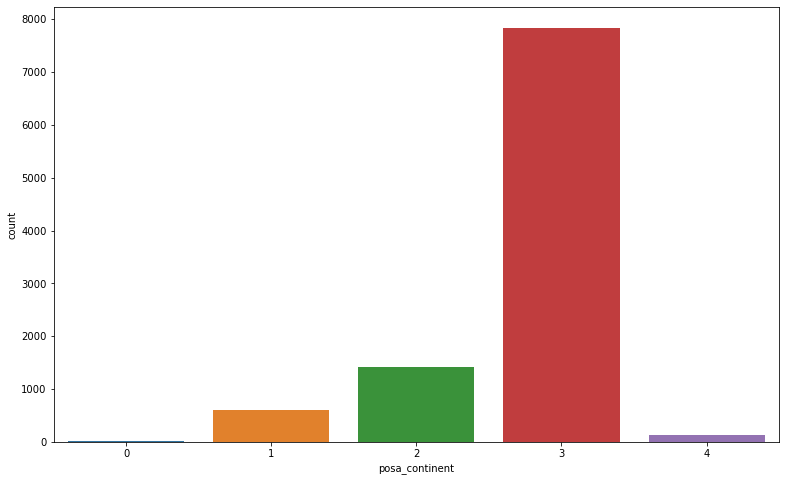

In [124]:
#frequency of continent
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('posa_continent', data=train,order=[0,1,2,3,4],ax=ax)

**Comments**
- We have no information regarding the continents names, so no more than especulations.
- Reasonably enough one could say that there is a business opportunity to grow in contienen o and 4.
- We could also say continent 3 has a better economic capacity or spending power.

C:\Users\sebastian.spena\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='hotel_continent', ylabel='count'>

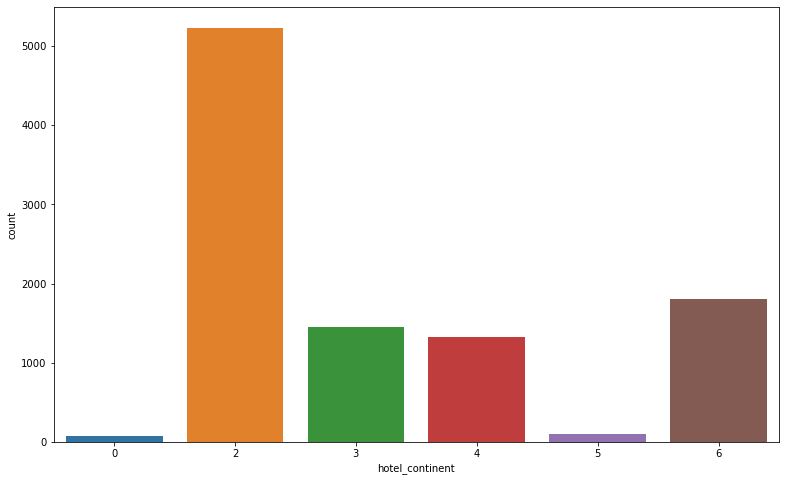

In [125]:
#continents and number of hotels
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('hotel_continent', data=train,order=[0,2,3,4,5,6],ax=ax)

**Comments**
- This could be interesting. There is 6 continents where you have hotels to book, but only 5 where expedia is making bookings.
- Also there are no hotels in continent 1 and 2 other continents with no bookings but with hotels.

In [126]:
#creating a subset for only bookings
bookings=train[train["is_booking"] == 1]

C:\Users\sebastian.spena\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='user_location_country', ylabel='count'>

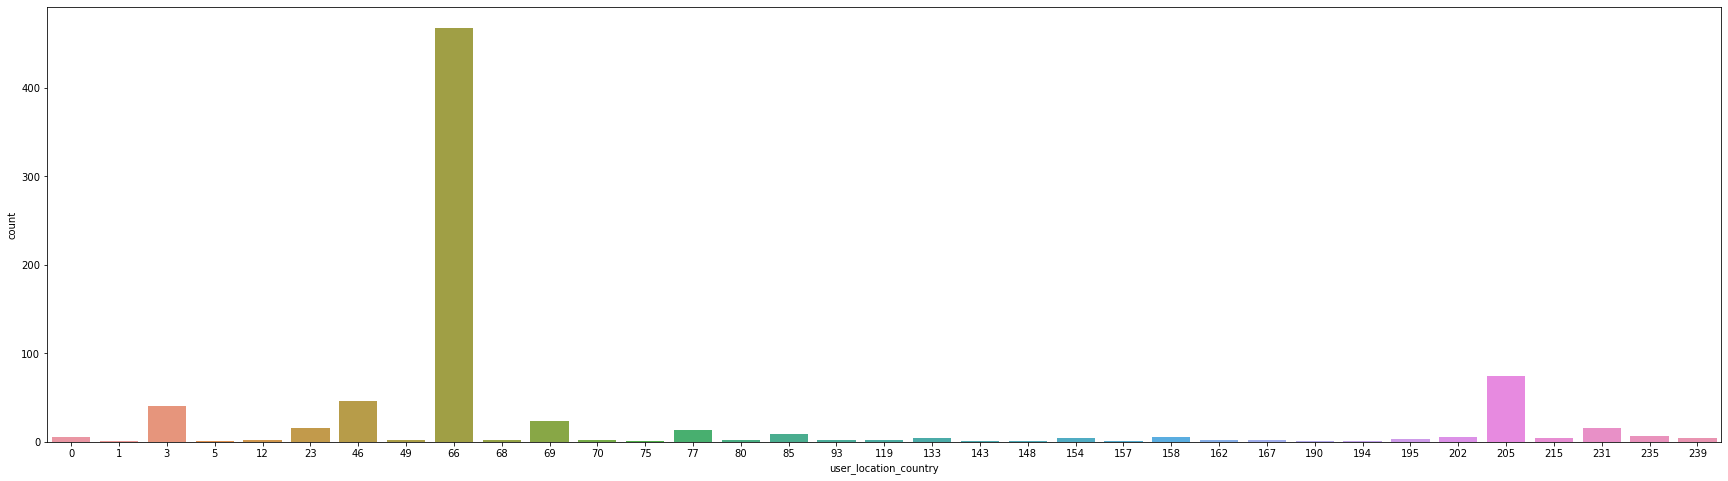

In [127]:
#countries where the customer travel from
fig, ax = plt.subplots()
fig.set_size_inches(30,8)
sns.countplot('user_location_country',data=bookings.sort_values(by=['user_location_country']))

**Comments**
- Country 66 is by far the most frequent country where people is traveling from. This could give us an insight about the population (China maybe?) or maybe about the purchasing power (US? China?) or perhaps about the situation regarding Expedia against competitors.
- For that we would need to come back to our client and understand and maybe challenge this information with some benchmarks.
- Could be perhaps that Expedia has a strong discount policy in that country?

C:\Users\sebastian.spena\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='hotel_country', ylabel='count'>

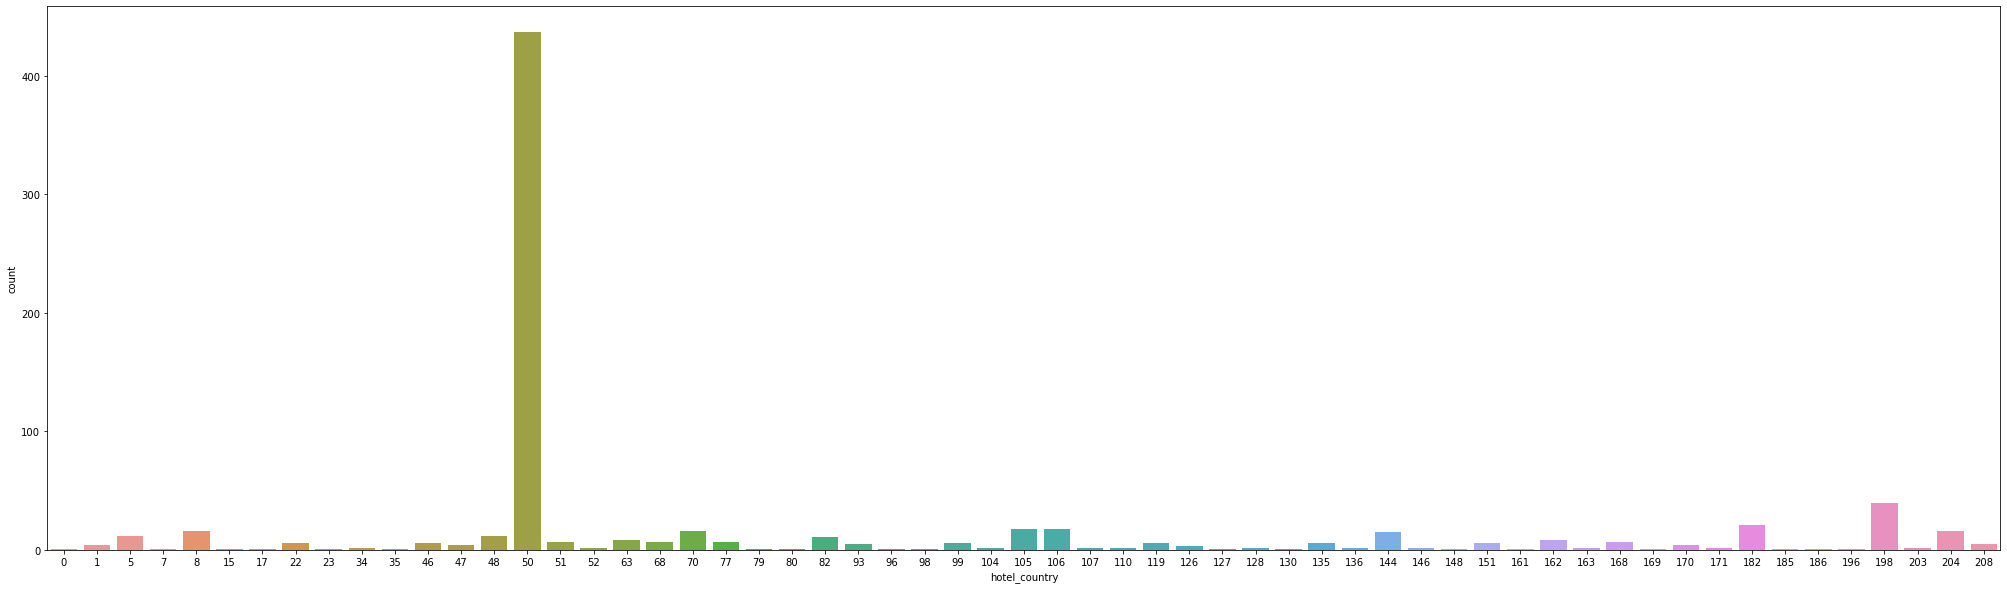

In [128]:
#frequency of destinations
fig, ax = plt.subplots()
fig.set_size_inches(35,10)
sns.countplot('hotel_country',data=bookings.sort_values(by=['hotel_country']))

**Comments**
- Interesting that country 50 is by far the most visited country for Expedia customers.
- Maybe is a hot destination in that particular year, or maybe is because there is some bias in the train dataset.

<AxesSubplot:xlabel='posa_continent', ylabel='count'>

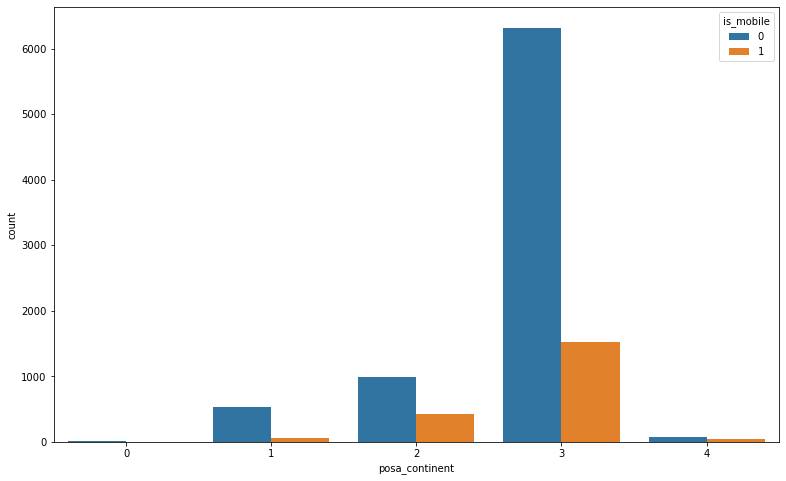

In [129]:
#bivariate analysis of continent and mobile
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot(x='posa_continent', hue='is_mobile', data = train)

**Comments**
- It looks like continent 1 has a less percentage of people from mobile (app) than from desktop (website)
- Maybe the UX and UI is not as good enough, or maybe we should recheck with other companies, to understand if it is an industry benchmark. Again, personally, I prefer website in my desktop for long, multisite trips than the app.

<AxesSubplot:>

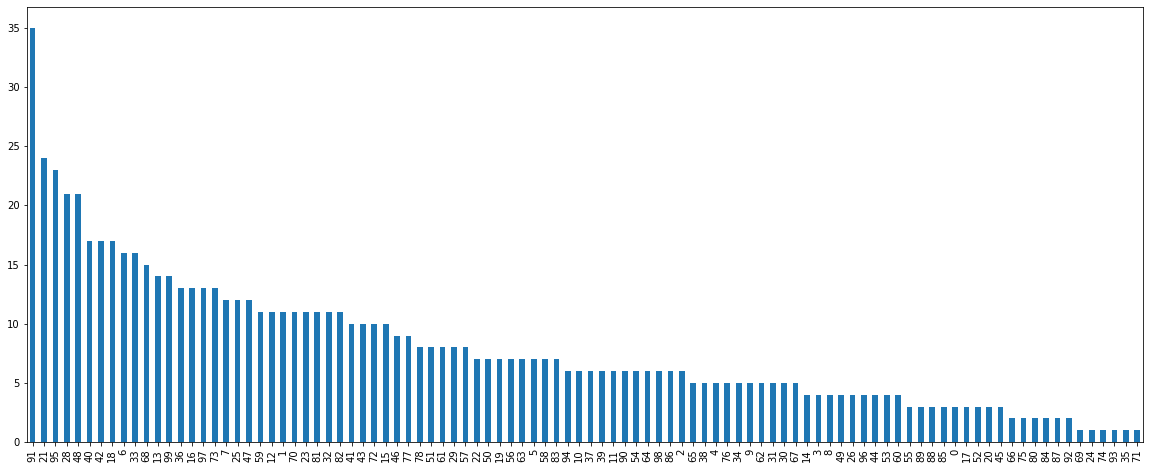

In [130]:
#frequency of hotel clusters
bookings['hotel_cluster'].value_counts().plot(kind='bar',figsize=(20,8))

**Comments**
- Cluster 91 is the most frequent hotel.

<AxesSubplot:xlabel='channel', ylabel='count'>

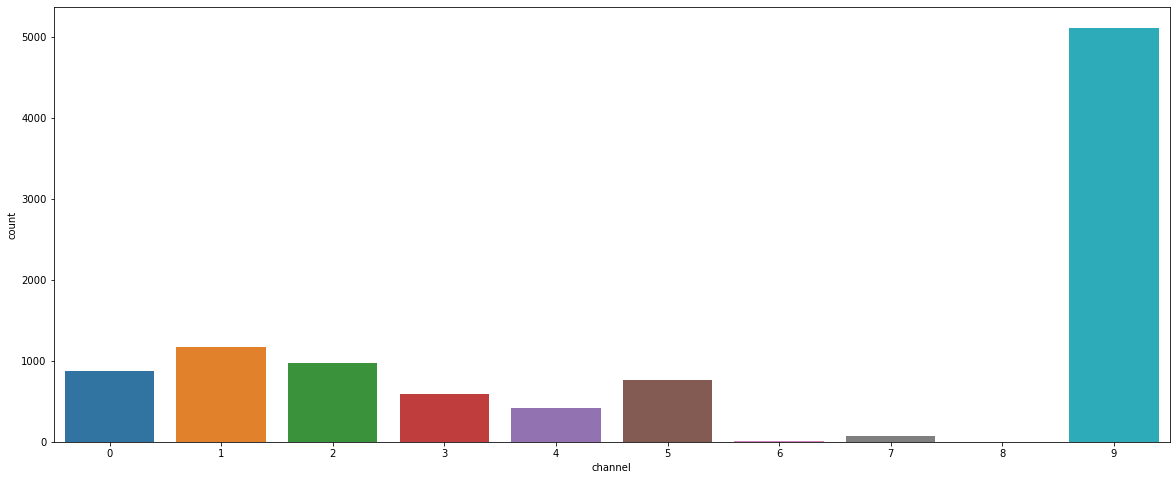

In [131]:
#analyzing channels
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x='channel', order=list(range(0,10)), data=train)

**Comments**
- Without any information regarding what number is each channel, or knowing more about the marketing strategy of the Company, is hard to interpret more than saying the obvious. Channel 9 is the most frequent. But how do we know if that has a strong alignment with the company business plan, or anything related to profitability. 

## 4. Feature Engineering and Feature Selection

Feature engineering is the process of using domain knowledge to extract features (characteristics, properties, attributes) from the dataset.

With the information that we have here, we could find out the duration of the trip by subtracting the date of check-in to check-out.

We could set a rule (with more industry knowledge) to create a category of short/long trips. Here you could find that there is a significant difference between business trips, ocasional getaways, long trips, etc.

Moreover, in hotel industry (and similar ones), is very useful to stratify your clients by month. That is, to manage your database through several ones splitted by month of origin. That could help you better understand your business and your customers, as it probably will not behave equally the ones that travel in winter vs summer, or in between. Sometimes, hotels have their own database breakdown. Like for example: "december 15th to january 7th", "spring break", etc.

In [132]:
#function to brake the date and extract day, month and year
def convert_date_into_days(df):
    #datetime features
    df['srch_ci']=pd.to_datetime(df['srch_ci'],infer_datetime_format = True,errors='coerce')
    df['srch_co']=pd.to_datetime(df['srch_co'],infer_datetime_format = True,errors='coerce')
    
    df['stay_duration'] = (df['srch_co'] - df['srch_ci']).astype('timedelta64[D]')
    df['no_of_prior_days_booking'] = (df['srch_ci'] - df['date_time']).astype('timedelta64[D]')
    
#     For hotel check-in
#     Month, Year, Day
    df['Cin_day'] = df["srch_ci"].apply(lambda x: x.day)
    df['Cin_month'] = df["srch_ci"].apply(lambda x: x.month)
    df['Cin_year'] = df["srch_ci"].apply(lambda x: x.year)
    return df

In [133]:
train = convert_date_into_days(train)

In [134]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9993 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date_time                  9993 non-null   datetime64[ns]
 1   site_name                  9993 non-null   int64         
 2   posa_continent             9993 non-null   int64         
 3   user_location_country      9993 non-null   int64         
 4   user_location_region       9993 non-null   int64         
 5   user_location_city         9993 non-null   int64         
 6   orig_destination_distance  9993 non-null   float64       
 7   user_id                    9993 non-null   int64         
 8   is_mobile                  9993 non-null   int64         
 9   is_package                 9993 non-null   int64         
 10  channel                    9993 non-null   int64         
 11  srch_ci                    9993 non-null   datetime64[ns]
 12  srch_c

In [135]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,stay_duration,no_of_prior_days_booking,Cin_day,Cin_month,Cin_year
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,3,2,50,628,1,4.0,15.0,27,8,2014
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,1,2,50,628,1,4.0,17.0,29,8,2014
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,1,2,50,628,1,4.0,17.0,29,8,2014
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,1,2,50,1457,80,5.0,105.0,23,11,2014
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,1,2,50,1457,21,5.0,105.0,23,11,2014


C:\Users\sebastian.spena\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Cin_year', ylabel='count'>

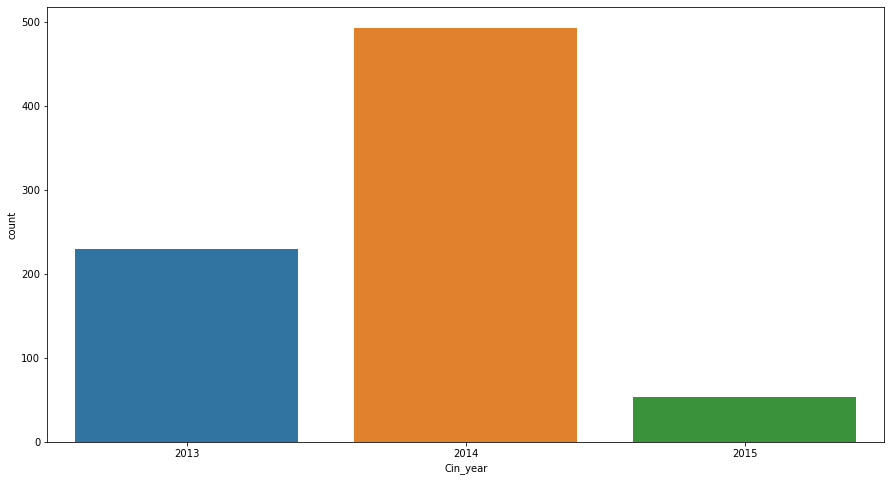

In [136]:
#visualize the booking by year
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.countplot('Cin_year',data=train[train['is_booking']==1])

**Comments**
- This could show that the business was at a very good level in 2013, spiking up in 2014 and decreasing in 2015. However, it's important to understand that we have no information of how this dataset was sampled whatsoever. Moreover, I'm working with only a subset of rows from the original dataset. If we have no information about the sampling method used, we could be concluding based on biased datasets. So, we should be really careful about concluding significant effects regarding the population.

C:\Users\sebastian.spena\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Cin_month', ylabel='count'>

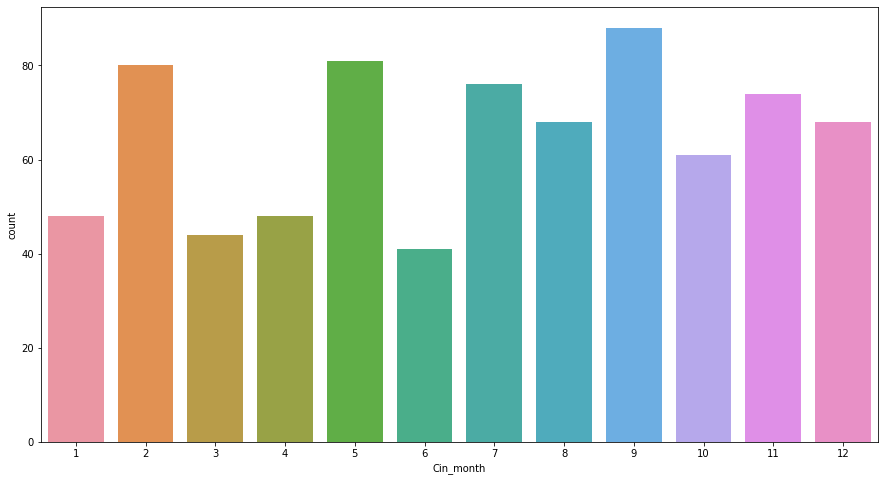

In [137]:
#visualizing seasonality
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.countplot('Cin_month',data=train[train['is_booking']==1],order=list(range(1,13)))

C:\Users\sebastian.spena\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Cin_day', ylabel='count'>

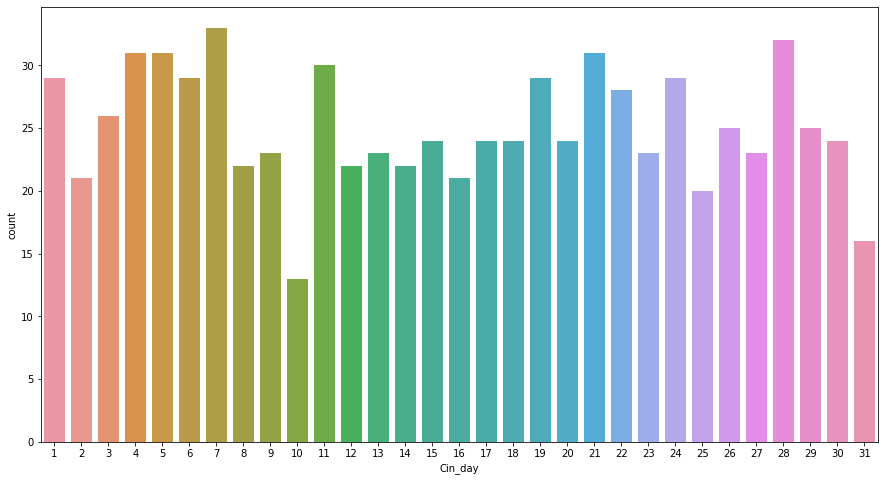

In [138]:
#visualizing bookings by day
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.countplot('Cin_day',data=train[train['is_booking']==1])

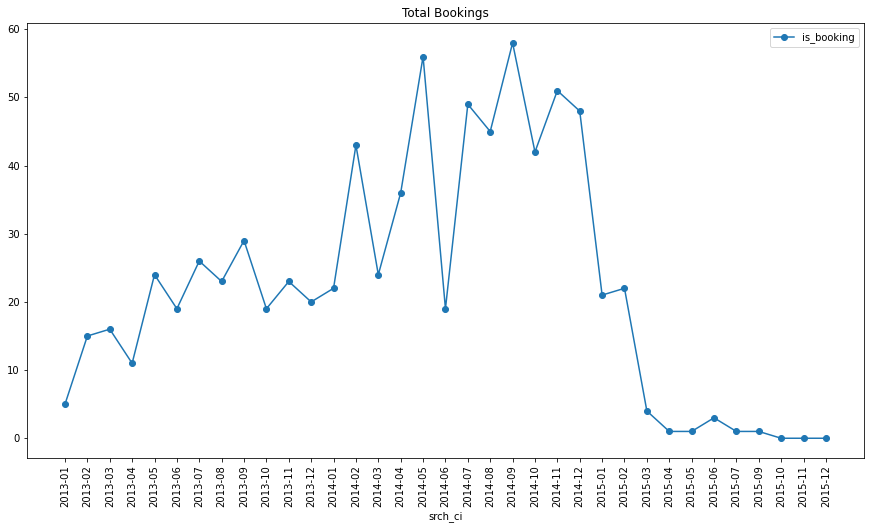

In [139]:
#business growth rate
no_of_bookings=train['srch_ci'].apply(lambda x: (str(x)[:7]) if x == x else np.nan)
date_bookings  = train.groupby(no_of_bookings)["is_booking"].sum()
ax1 = date_bookings.plot(legend=True,marker='o',title="Total Bookings", figsize=(15,8)) 
ax1.set_xticks(range(len(date_bookings)))
xlabels = ax1.set_xticklabels(date_bookings.index.tolist(), rotation=90)

**Comments**
- Again there could be a problem with the sample. Regardless of that, it looks like there has been an issue in the business. Maybe an economic crisis, maybe it was due to competence problem. We should get back to our Client to understand more.

<AxesSubplot:xlabel='stay_duration', ylabel='count'>

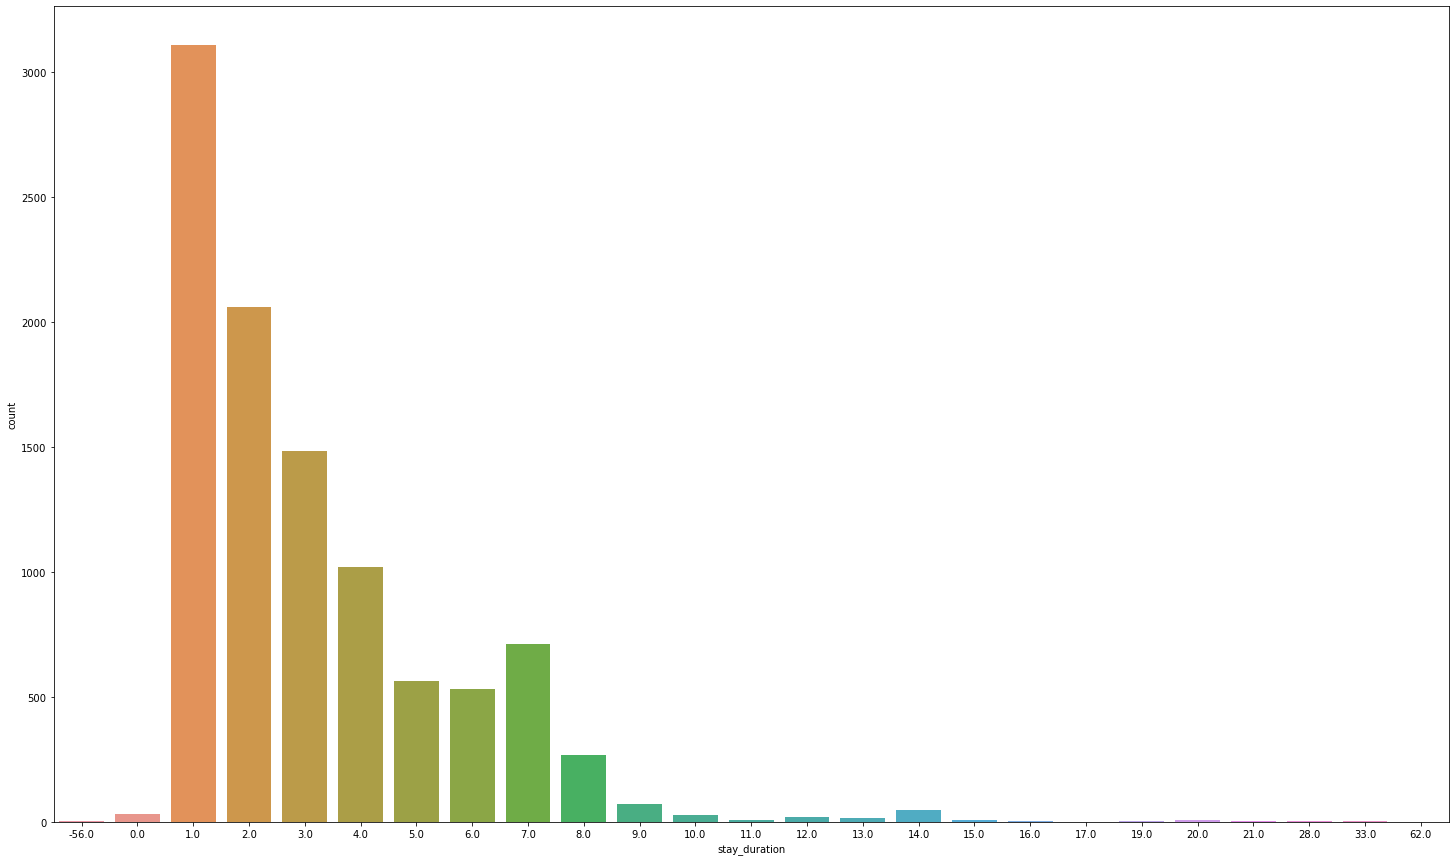

In [140]:
#frequency of number of days of stay lenght
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
sns.countplot(x="stay_duration", data=train)

In [141]:
train['stay_duration'].max()

62.0

**Comments**
- From this sample, it seems like the most frequent number of days that each customer stays is around 1 day. This could be for a number of reasons. We are not 100% sure the customer didn't stay more time, by booking 1 day only just to check if the hotel was ok enough to stay.
- It also looks like there are some travelers who had stayed for 0 days. This is probably an error or a cancelation.
- It could be also related to business trips.
- It could relate to long trips where you jump from one city to another.
- Anyway, we should get back to our client for further explanation and revalidation.

## 5. Data Cleaning and Model Preparation

In [142]:
train.corr()["hotel_cluster"]

site_name                   -0.025890
posa_continent               0.022119
user_location_country       -0.000355
user_location_region         0.031297
user_location_city           0.008378
orig_destination_distance    0.009625
user_id                     -0.038709
is_mobile                   -0.002336
is_package                   0.068731
channel                      0.010956
srch_adults_cnt              0.003625
srch_children_cnt            0.014931
srch_rm_cnt                  0.001037
srch_destination_id         -0.018810
srch_destination_type_id    -0.059106
is_booking                  -0.010280
cnt                         -0.002052
hotel_continent             -0.019825
hotel_country               -0.044470
hotel_market                 0.021687
hotel_cluster                1.000000
stay_duration                0.053497
no_of_prior_days_booking     0.045974
Cin_day                      0.003086
Cin_month                    0.001190
Cin_year                    -0.000936
Name: hotel_

In [143]:
#removing unnecessary columns
columns = ['date_time', 'srch_ci', 'srch_co']
train.drop(columns=columns,axis=1,inplace=True)
test.drop(columns=columns,axis=1,inplace=True)

In [144]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9993 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   site_name                  9993 non-null   int64  
 1   posa_continent             9993 non-null   int64  
 2   user_location_country      9993 non-null   int64  
 3   user_location_region       9993 non-null   int64  
 4   user_location_city         9993 non-null   int64  
 5   orig_destination_distance  9993 non-null   float64
 6   user_id                    9993 non-null   int64  
 7   is_mobile                  9993 non-null   int64  
 8   is_package                 9993 non-null   int64  
 9   channel                    9993 non-null   int64  
 10  srch_adults_cnt            9993 non-null   int64  
 11  srch_children_cnt          9993 non-null   int64  
 12  srch_rm_cnt                9993 non-null   int64  
 13  srch_destination_id        9993 non-null   int64

In [145]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   site_name                  10000 non-null  int64  
 2   posa_continent             10000 non-null  int64  
 3   user_location_country      10000 non-null  int64  
 4   user_location_region       10000 non-null  int64  
 5   user_location_city         10000 non-null  int64  
 6   orig_destination_distance  10000 non-null  float64
 7   user_id                    10000 non-null  int64  
 8   is_mobile                  10000 non-null  int64  
 9   is_package                 10000 non-null  int64  
 10  channel                    10000 non-null  int64  
 11  srch_adults_cnt            10000 non-null  int64  
 12  srch_children_cnt          10000 non-null  int64  
 13  srch_rm_cnt                10000 non-null  int6

In [146]:
#creating the x and y dataframes
Y = train['hotel_cluster']
X = train.drop(['hotel_cluster'],axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9993 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   site_name                  9993 non-null   int64  
 1   posa_continent             9993 non-null   int64  
 2   user_location_country      9993 non-null   int64  
 3   user_location_region       9993 non-null   int64  
 4   user_location_city         9993 non-null   int64  
 5   orig_destination_distance  9993 non-null   float64
 6   user_id                    9993 non-null   int64  
 7   is_mobile                  9993 non-null   int64  
 8   is_package                 9993 non-null   int64  
 9   channel                    9993 non-null   int64  
 10  srch_adults_cnt            9993 non-null   int64  
 11  srch_children_cnt          9993 non-null   int64  
 12  srch_rm_cnt                9993 non-null   int64  
 13  srch_destination_id        9993 non-null   int64

In [147]:
#dividing the train dataset 70/30
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
print(len(X_train))
print(len(X_test))

6995
2998


In [148]:
#setting baseline accuracy
from sklearn.metrics import accuracy_score
test_rows = Y_test.shape[0]
predicted_values = np.ones(test_rows) * 91
accuracy_score(Y_test, predicted_values)

0.028352234823215475

In [149]:
Y_test.shape[0]

2998

## 6. Machine Learning Modeling and Hyperparameter Tuning

### 6.1 Random Forests

Random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes or mean/average prediction of the individual trees.

When creating a machine learning model, we have to define model architecture. Most of the times it's necessary to experiment through- At first we don't know what is optimal, so we need to explore a range of possibilities. In a complex and real world cloud machine learning we would perform exploration and selection of the optimal model automatically. 
In this case and given the limitations, I have done so manually.

Main issues adressed through manual hyperparameter tuning: 
- Maximum depth for the tree?
- Number leaf nodes?
- Information gain calculation: Gini or entropy?
- How many trees should I include in my random forest?

Eventually we should define a criteria to judge the model and a cross-validation method.

In [150]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#Instantiate
rf = RandomForestClassifier(n_estimators=80)
rf.fit(X_train, Y_train)

#Prediction
rf_train_prediction = rf.predict(X_train)
rf_test_prediction = rf.predict(X_test)

#Accuracy
train_accuracy = accuracy_score(Y_train,rf_train_prediction)
test_accuracy = accuracy_score(Y_test,rf_test_prediction)
rf_accuracy = test_accuracy

#Print
print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Train Accuracy: 89.62%
Test Accuracy: 32.49%


**Comments**
- It's clearer that the model is overfitting. Our model doesn’t generalize well from our training data to unseen data.
- Main reason why this happens is because we have a modeling error that occurs when a function is too aligned to the train dataset. As a consequence, the model is useful only for the training observations, but performs very poorly in the test dataset.
- Other reasonable explanation could be related to sampling. If we are working with noisy data, it could lead If the algorithm is too complex or too flexible, it can end up memorizing the noise instead of finding the pattern underlying.

In [151]:
train.shape

(9993, 26)

In [152]:
#creating a subset
train_subset = train.sample(700)

In [153]:
train_subset.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,stay_duration,no_of_prior_days_booking,Cin_day,Cin_month,Cin_year
3951,2,3,66,220,43026,4703.589000,23234,0,0,2,...,1,2,50,212,21,7.0,118.0,1,4,2015
9175,33,2,70,91,3535,1833.809641,52826,0,0,0,...,1,3,106,107,6,5.0,59.0,23,2,2014
2126,24,2,3,50,5703,1833.809641,9616,0,0,1,...,1,3,182,46,29,2.0,2.0,29,12,2013
6403,2,3,66,462,1263,2664.349500,37950,0,0,9,...,1,2,50,213,26,7.0,6.0,20,8,2014
9481,2,3,231,69,8251,1833.809641,53412,0,0,9,...,2,3,182,46,39,2.0,22.0,2,1,2015


In [154]:
train_subset.shape

(700, 26)

In [155]:
X_subset = train.drop(['hotel_cluster'],axis=1)
Y_subset = train['hotel_cluster']


In [156]:
X_train_subset, X_test_subset, Y_train_subset, Y_test_subset = train_test_split(X_subset, Y_subset, test_size=0.15, random_state=1)

In [157]:
rf_tuning = RandomForestClassifier(n_estimators=5, criterion = 'entropy', max_depth=20)
rf_tuning.fit(X_train_subset, Y_train_subset)

#Prediction
rf_train_prediction = rf_tuning.predict(X_train_subset)
rf_test_prediction = rf_tuning.predict( X_test_subset)

#Accuracy
train_accuracy = accuracy_score(Y_train_subset,rf_train_prediction)
test_accuracy = accuracy_score(Y_test_subset,rf_test_prediction)
rf_tuning_accuracy = test_accuracy

#Print
print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Train Accuracy: 81.94%
Test Accuracy: 32.15%


### 6.2 Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

Is simple and powerful for classification problems. Also, it is simple to understand, and is fast to build a model and make predictions.

In [158]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

#Instantiate
gnb = GaussianNB()
gnb.fit(X_train,Y_train) 

#Prediction
gnb_train_prediction = gnb.predict(X_train)
gnb_test_prediction = gnb.predict(X_test)

#Accuracy
train_accuracy=accuracy_score(Y_train,gnb_train_prediction)
test_accuracy=accuracy_score(Y_test,gnb_test_prediction)
gnb_accuracy = test_accuracy

#Print
print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Train Accuracy: 11.45%
Test Accuracy: 8.74%


**Comments**
- Naive Bayes is showing a very poor performance if consider les than 15% of accuracy. are not good enough to generalize over the entire data and produce very less results compared to other methods.
- Probably the main reason why is performing bad is because it assumes the features are independent, the probabilities are incorrect if this assumption is not correct.

### 6.3 Logistic Regression

Logistic regression is a statistical model that uses a logistic function to model a binary dependent variable (true/false, yes/no, 0/1, etc), although many more complex extensions exist. The model is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick.

In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#Instantiate
lr = LogisticRegression()
lr.fit(X_train, Y_train)

#Prediction
lr_train_prediction = lr.predict(X_train)
lr_test_prediction = lr.predict(X_test)

#Accuracy
train_accuracy=accuracy_score(Y_train,lr_train_prediction)
test_accuracy=accuracy_score(Y_test,lr_test_prediction)
lr_accuracy = test_accuracy

#Print
print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Train Accuracy: 4.70%
Test Accuracy: 4.74%


C:\Users\sebastian.spena\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Comments**
- The model's predicted probabilities do not follow the true probabilities.
- Clearly not a good model for this case.

### 6.4. KNN

K-Nearest Neighbors (KNN) is one of the simplest algorithms for regression and classification problems. KNN algorithms use data and classify new data points based on similarity measures (e.g. distance function). The data is assigned to the class which has the nearest neighbors.

In [160]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score

#Instantiate
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train,Y_train)

#Prediction
knn_train_prediction = knn.predict(X_train)
knn_test_prediction = knn.predict(X_test)

#Accuracy
train_accuracy=accuracy_score(Y_train,knn_train_prediction)
test_accuracy=accuracy_score(Y_test,knn_test_prediction)
knn_accuracy = test_accuracy

#Print
print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0)) #42
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0)) #21

Train Accuracy: 42.73%
Test Accuracy: 20.25%


**Comments**
- The model's prediction will be correct 42% of the times, but still has a significant difference vs de test set, implying that there is still a bad estimator or has a lot of noise in the data.

### 6.5 XGBoost

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework.

Gradient boosting relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error. The key idea is to set the target outcomes for this next model in order to minimize the error. Each case is based on the gradient of the error with respect to the prediction. Each new model takes a step in the direction that minimizes prediction error, in the space of possible predictions for each training case.

In [161]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

#Instantiate
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)

#Prediction
xgb_train_prediction = xgb.predict(X_train)
xgb_test_prediction = xgb.predict(X_test)

#Accuracy
train_accuracy = accuracy_score(Y_train, xgb_train_prediction)
test_accuracy = accuracy_score(Y_test, xgb_test_prediction)
xgb_accuracy = test_accuracy

#Printing
print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0)) #52
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0)) #28

C:\Users\sebastian.spena\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:28:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 89.32%
Test Accuracy: 34.06%


**Comments**
- XGBoost has a performance very slightly less to that of Random Forest. This is because both methods work in a similar way, handling both categorical features efficiently.

### 6.6 Decision Tree

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

In [162]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#Instantiate
dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)

#Prediction
dt_train_prediction = dt.predict(X_train)
dt_test_prediction = dt.predict(X_test)

#Accuracy
train_accuracy = accuracy_score(Y_train, dt_train_prediction)
test_accuracy = accuracy_score(Y_test, dt_test_prediction)
dt_accuracy = test_accuracy

#Printing
print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0)) #70
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0)) #27

Train Accuracy: 89.64%
Test Accuracy: 31.12%


**Comments**
- Again, Decision Tree has a performance very similar to XGBoost and Random Forest. But not improving our first model.

## 7. Model Comparison

In [163]:
accuracy=[rf_accuracy*100,gnb_accuracy*100,lr_accuracy*100,knn_accuracy*100,xgb_accuracy*100,dt_accuracy*100]
accuracy

[32.48832555036691,
 8.739159439626418,
 4.736490993995997,
 20.246831220813878,
 34.056037358238825,
 31.120747164776517]

In [164]:
algorithms=["Random Forest","Guassian Naive Bayes","Logistic Regression","KNN","XGBoost","Decsion trees"]

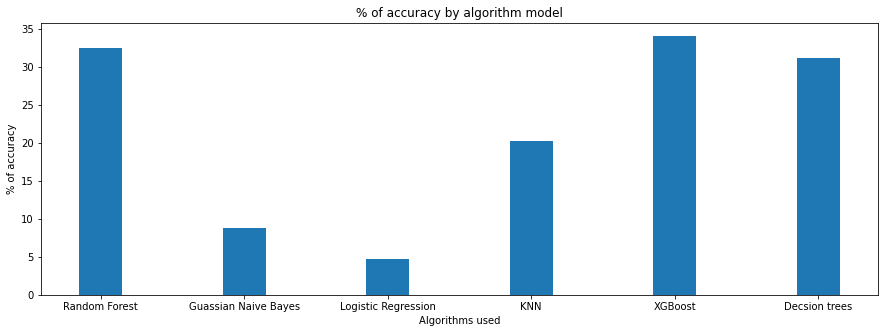

In [165]:
plt.figure(figsize=(15,5))
plt.bar(algorithms,accuracy,width=0.3)
plt.xlabel('Algorithms used')
plt.ylabel('% of accuracy')
plt.title('% of accuracy by algorithm model')
plt.show()

## 8. Solution

**Comments**
- I have searched on internet specifically on Kaggle to understand how to solve this problem. So, from the random forest model I should work on a set of 5 options.

In [166]:
prob_predictions_train = rf.predict_proba(X_train)
prob_predictions_test = rf.predict_proba(X_test)

In [167]:
prob_predictions_train.shape

(6995, 100)

In [168]:
top_train_hotel_clusters = prob_predictions_train.argsort(axis=1)
top_train_hotel_clusters

array([[ 0, 72, 71, ..., 85, 60, 57],
       [ 0, 70, 69, ..., 13, 72, 18],
       [ 0, 72, 71, ..., 76, 57, 40],
       ...,
       [ 0, 71, 70, ...,  6, 15, 42],
       [ 0, 69, 68, ..., 25, 18, 21],
       [ 0, 72, 71, ..., 36,  2,  8]], dtype=int64)

In [169]:
prob_predictions_train[0,53], prob_predictions_train[0,0]

(0.0, 0.0)

In [170]:
prob_predictions_train[0,49]

0.0

In [171]:
prob_predictions_train.argsort(axis=1)

array([[ 0, 72, 71, ..., 85, 60, 57],
       [ 0, 70, 69, ..., 13, 72, 18],
       [ 0, 72, 71, ..., 76, 57, 40],
       ...,
       [ 0, 71, 70, ...,  6, 15, 42],
       [ 0, 69, 68, ..., 25, 18, 21],
       [ 0, 72, 71, ..., 36,  2,  8]], dtype=int64)

In [172]:
np.flip(prob_predictions_train.argsort(axis=1), axis=1)

array([[57, 60, 85, ..., 71, 72,  0],
       [18, 72, 13, ..., 69, 70,  0],
       [40, 57, 76, ..., 71, 72,  0],
       ...,
       [42, 15,  6, ..., 70, 71,  0],
       [21, 18, 25, ..., 68, 69,  0],
       [ 8,  2, 36, ..., 71, 72,  0]], dtype=int64)

In [173]:
temp = np.flip(prob_predictions_train.argsort(axis=1), axis=1)[:,0:5]
temp

array([[57, 60, 85, 61, 27],
       [18, 72, 13, 28, 21],
       [40, 57, 76, 14, 47],
       ...,
       [42, 15,  6, 48, 16],
       [21, 18, 25, 83, 72],
       [ 8,  2, 36, 62, 99]], dtype=int64)

In [174]:
Y_train

2189    57
1964    18
9354    40
8801    78
9395    32
        ..
2896    35
7816    50
905     42
5194    21
235      2
Name: hotel_cluster, Length: 6995, dtype: int64

In [175]:
rf_train_prediction

array([63, 57, 29, ..., 42, 21,  8], dtype=int64)

In [176]:
y_train_index_reset = Y_train.reset_index(drop=True)

In [177]:
y_train_index_reset

0       57
1       18
2       40
3       78
4       32
        ..
6990    35
6991    50
6992    42
6993    21
6994     2
Name: hotel_cluster, Length: 6995, dtype: int64

In [178]:
# y_train_index_reset = Y_train.reset_index()
predicted_in_top_5 = 0
for i in range(len(y_train_index_reset)-1):
    if y_train_index_reset[i] in temp[i,:]:
        predicted_in_top_5 = predicted_in_top_5 + 1
predicted_in_top_5

6938

In [179]:
predicted_in_top_5/len(y_train_index_reset) * 100

99.18513223731237

In [180]:
len(y_train_index_reset)

6995

In [181]:
k = 5
temp = np.flip(prob_predictions_train.argsort(axis=1), axis=1)[:,0:k]
predicted_in_top_k = 0
for i in range(len(y_train_index_reset)-1):
    if y_train_index_reset[i] in temp[i,:]:
        predicted_in_top_k = predicted_in_top_k + 1
predicted_in_top_k
accuracy = predicted_in_top_k/len(y_train_index_reset) * 100
print(accuracy)

99.18513223731237


In [182]:
#Let's do the same for test

k = 5
temp = np.flip(prob_predictions_test.argsort(axis=1), axis=1)[:,0:k]
y_test_index_reset = Y_test.reset_index(drop=True)
predicted_in_top_k = 0
for i in range(len(y_test_index_reset)-1):
    if y_test_index_reset[i] in temp[i,:]:
        predicted_in_top_k = predicted_in_top_k + 1
predicted_in_top_k
accuracy = predicted_in_top_k/len(y_test_index_reset) * 100
print(accuracy)

57.37158105403603
